<div class="alert alert-success">
  <strong>DATASET:</strong> 5j0n_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5
    <br/>
    <strong>PROJECTION DISTANCE (d_P):</strong> estimated distances (model nosiy_var0.h5)
</div>

# Reconstruction

<div class="alert alert-danger">
  <strong>NOTE:</strong> This is done on a PC where I don't need X11 forwarding (since <code>mayavi</code> is a graphic package, and the lab's server doesn't support X11).
</div>

Reference: https://tomroelandts.com/articles/astra-toolbox-tutorial-reconstruction-from-projection-images-part-2

In [10]:
# !pip install mayavi

In [1]:
# !pip install gast

In [16]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
import matplotlib.pyplot as plt
import astra
import h5py
import os
import mrcfile
#from tvtk.api import tvtk
from mayavi import mlab
from IPython.display import Image
import sys
sys.path.append("../..") 
from cryoem.reconstruction import reconstruct
from cryoem.conversions import quaternion2euler

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13809885738767239228
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16204302794551564192
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14121096398646730065
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3082158080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4795286246502892379
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


---

# Reconstruction with Ground-Truth Angles

## Reconstruction

In [4]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
from cryoem.rotation_matrices import RotationMatrix
import astra
import mrcfile
from pathlib import Path

def reconstruct(projections, angles, mrc_filename=None, overwrite=False, vol_shape=None):
    # Generate orientation vectors based on angles
    orientation_vectors   = RotationMatrix(angles)

    # Reshape projections correctly 
    projections1 = np.transpose(projections, (1, 0, 2))
    
    # Get projection dimension
    proj_size = projections1.shape[0]
    if vol_shape is None:
        vol_shape = [proj_size, proj_size, proj_size]

    # Create projection 2D geometry in ASTRA
    proj_geom = astra.create_proj_geom('parallel3d_vec', proj_size, proj_size, orientation_vectors)
    projections_id = astra.data3d.create('-sino', proj_geom, projections1)

    # Create reconstruction.
    vol_geom = astra.creators.create_vol_geom(vol_shape[1], vol_shape[2], vol_shape[0])
    reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
    
    alg_cfg = astra.astra_dict('BP3D_CUDA')
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data3d.get(reconstruction_id)


    # Limit and scale reconstruction.
    reconstruction[reconstruction < 0] = 0
    reconstruction /= np.max(reconstruction)
    reconstruction = np.round(reconstruction * 255).astype(np.uint8)

    # Cleanup.
    astra.algorithm.delete(algorithm_id)
    astra.data3d.delete(reconstruction_id)
    astra.data3d.delete(projections_id)


    # Save reconstruction to mrc file for chimera
    if mrc_filename:
        Path(mrc_filename).parent.mkdir(parents=True, exist_ok=True)
        with mrcfile.new(mrc_filename, overwrite=overwrite) as mrc:
            mrc.set_data(reconstruction)
#             mrc.header.nx=75
#             mrc.header.nx=57
#             mrc.header.nx=69
            mrc.header.cella = (275, 209, 253)
            mrc.header.cellb = (90,90,90)
            mrc.header.origin= (69.753, 63.1, 26.546001)
            mrc.header.ispg=0
            #mrc.header.mode=2
        
    return reconstruction

def reconstruct_from_file(input_file, limit=3000, mrc_filename=None):
    data = np.load(f'data/{input_file}.npz')
    projections, angles = data["arr_0"].astype(np.float64)[:limit, :, :], data["arr_1"].astype(np.float64)[:limit, :]

    return reconstruct(projections, angles, mrc_filename)


In [9]:
data = np.load(f"../../data/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

In [10]:
# half coverage (AngCoverage=0.5)
projections_filename = "../../data/results_pipeline_5j0n_noise0/5j0n_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.5_AngShift0.0,0.0,0.0_NEW.h5"

# load structures
data = h5py.File(projections_filename, 'r')

projections = data["Projections"][test_idx]
angles_true = data["Angles"][test_idx]

In [11]:
reconstruction = reconstruct(projections[:3000], angles_true[:3000], mrc_filename="../../data/results_pipeline_5j0n_noise0/5j0n_gt.mrc", overwrite=True, vol_shape=[69, 57, 75])


In [7]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

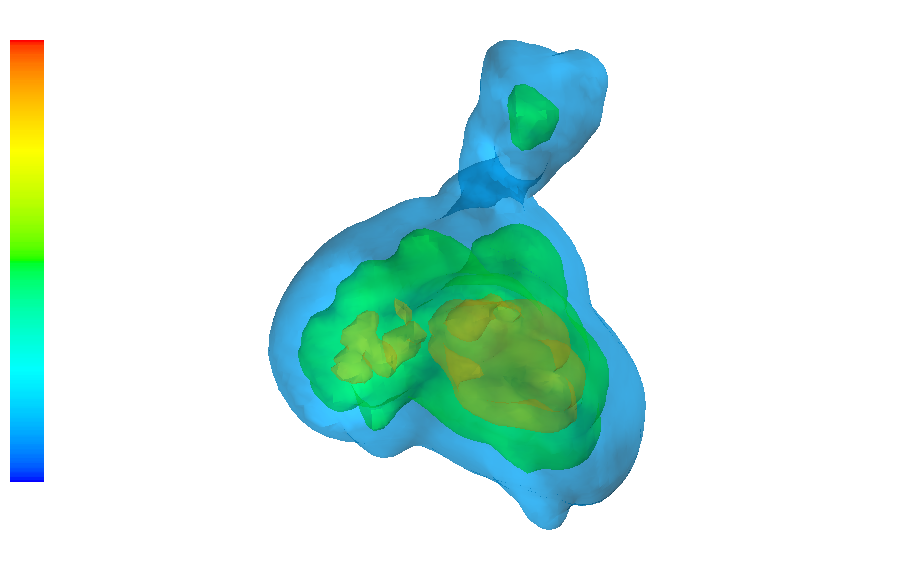

In [9]:
Image(filename='../../data/results_pipeline_5j0n_noise0/ground_truth_reconstruction_5j0n.png')

---

# Reconstruction after Angle Recovery

## Reconstruction

In [10]:
# data = np.load("../../data/results_pipeline_5j0n_noise0/angle_recovery/5j0n_orientation_recovery_noise0.npz")
# q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

# angles_predicted = quaternion2euler(q_predicted)

In [11]:
# np.save("../../data/results_pipeline_5j0n_noise0/angle_recovery__angles_predicted.npy", angles_predicted)

In [8]:
data = np.load(f"../../data/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

In [9]:
projections_filename = "../../data/results_pipeline_5j0n_noise0/5j0n_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.5_AngShift0.0,0.0,0.0_NEW.h5"

# load structures
data = h5py.File(projections_filename, 'r')

projections = data["Projections"][test_idx]

In [10]:
projections.shape

(1650, 116, 116)

In [12]:
angles_predicted = np.load("../../data/results_pipeline_5j0n_noise0/angle_recovery__angles_predicted.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename="../../data/results_pipeline_5j0n_noise0/5j0n_ap.mrc", overwrite=True, vol_shape=None)

In [26]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

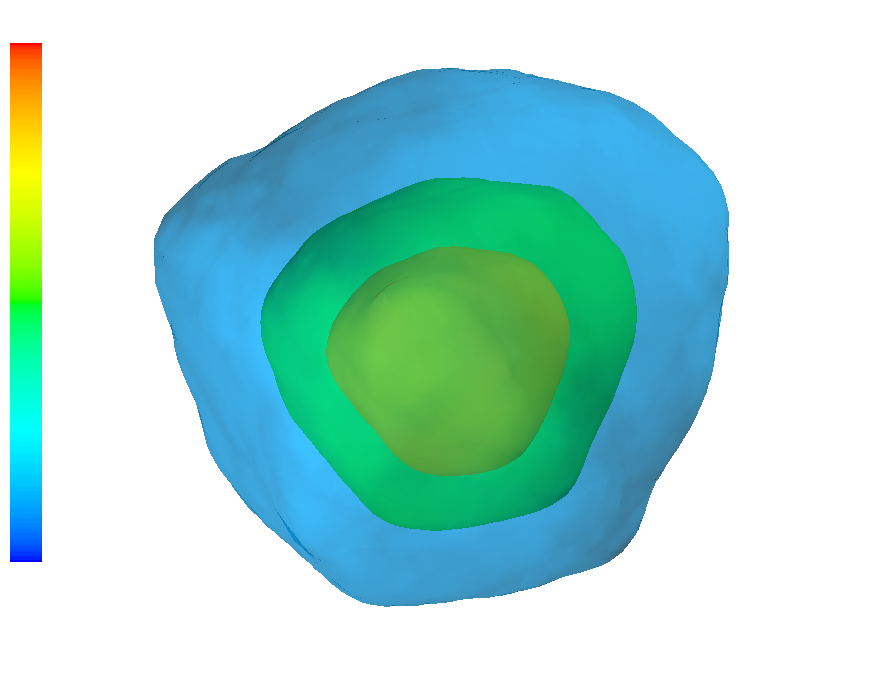

In [27]:
Image(filename='../../data/results_pipeline_5j0n_noise0/angles_predicted_reconstruction_5j0n.png')

---

# Reconstruction after Angle Alignment

## Reconstruction

In [24]:
# data = np.load("../../data/results_pipeline_5j0n_noise0/angle_recovery/5j0n_orientation_recovery_noise0.npz")
# q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

# angles_predicted = quaternion2euler(q_predicted)

In [25]:
# angles_predicted = np.load("../../data/results_pipeline_5j0n_noise0/angle_recovery__angles_predicted.npy")


# from cryoem.angle_alignment import training_angle_alignment, update_quaternion
# from tensorflow.keras.optimizers import Adagrad, Ftrl

In [26]:
# m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
#                                                         steps=300, 
#                                                         batch_size=256, 
#                                                         optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
#                                                         angles_true=angles_true[test_idx], 
#                                                         angles_predicted=angles_predicted)

In [27]:
# q_predicted_rotated =  update_quaternion(m, a_R, q_predicted, dtype=np.float64)

# angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

# np.save("../../data/results_pipeline_5j0n_noise0/angle_recovery__angles_predicted_rotated.npy", angles_predicted_rotated)

In [12]:
data = np.load(f"../../data/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

In [14]:
projections_filename = "../../data/results_pipeline_5j0n_noise0/5j0n_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.5_AngShift0.0,0.0,0.0_NEW.h5"

# load structures
data = h5py.File(projections_filename, 'r')

projections = data["Projections"][test_idx]

In [15]:
#projections = np.load("data/projections.npy")
angles_predicted = np.load("../../data/results_pipeline_5j0n_noise0/angle_recovery__angles_predicted_rotated.npy")
reconstruction = reconstruct(projections[:3000], angles_predicted[:3000], mrc_filename="../../data/results_pipeline_5j0n_noise0/5j0n_apr.mrc", overwrite=True, vol_shape=[69, 57, 75])

In [44]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

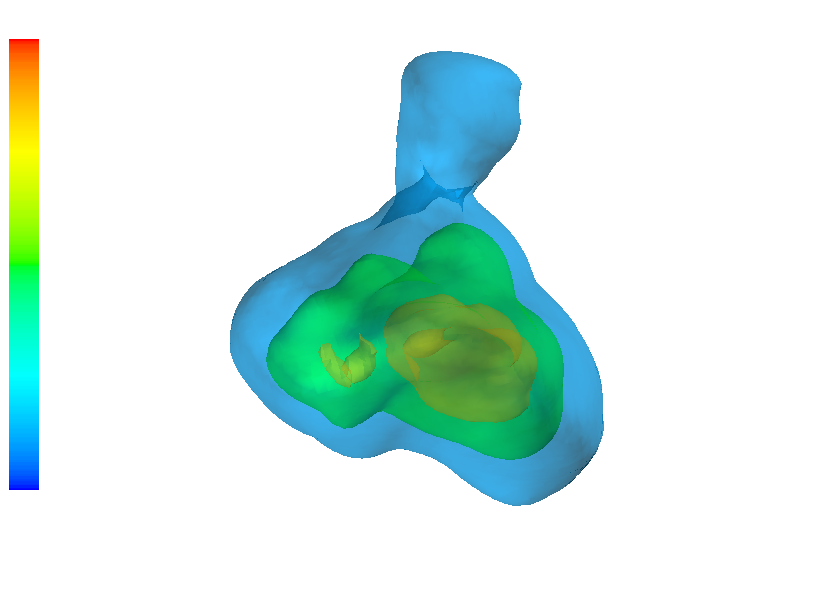

In [23]:
Image(filename='../../data/results_pipeline_5j0n_noise0/angles_predicted_rotated_reconstruction_5j0n.png')

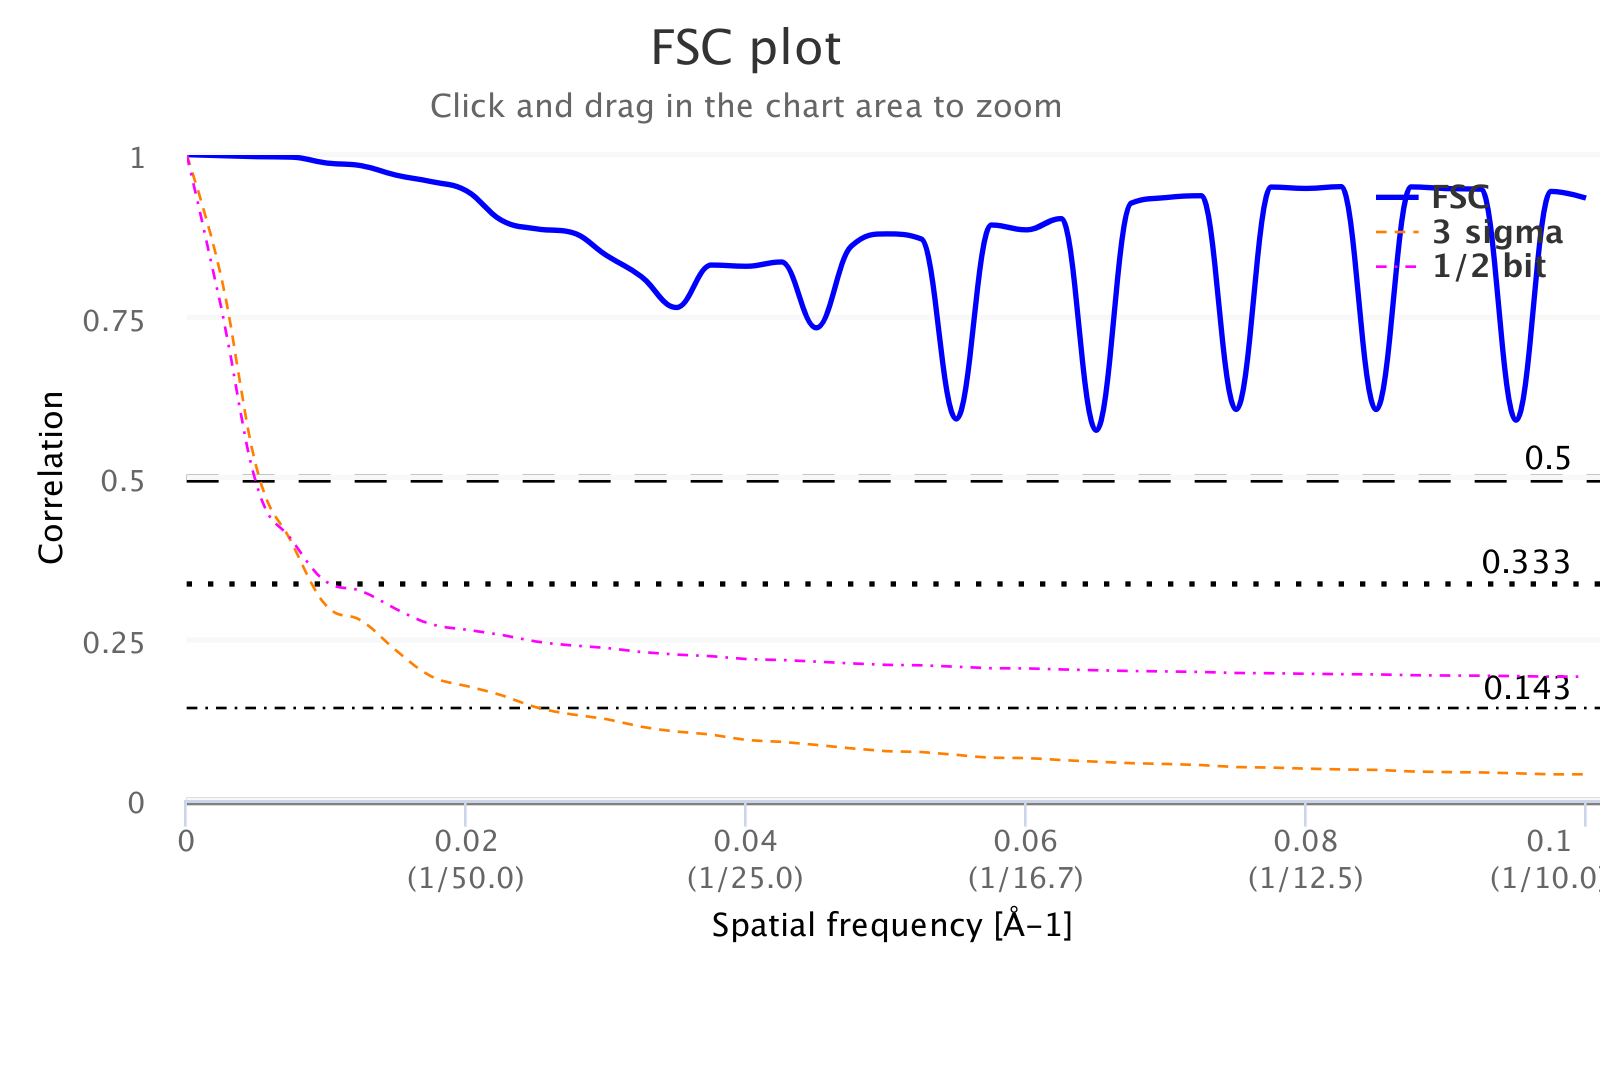

In [48]:
Image(filename='../../data/results_pipeline_5j0n_noise0/FSC_5j0n_gt_5j0n_apr.png')

---